In [13]:
import numpy as np
import matplotlib.pyplot as plt
from errorPropPendulum import *
from scipy.special import erfc                         # Error function, to get integral of Gaussian
from scipy import stats

sys.path.append('../AppStat2023/External_Functions')
from ExternalFunctions import UnbinnedLH, BinnedLH, Chi2Regression
from ExternalFunctions import nice_string_output, add_text_to_ax   # Useful functions to print fit results on figure


In [14]:
blind = True

if blind:
    blinding = np.random.uniform()
else:
    blinding = 0

experiment_by = ["anders", "christine", "Jakob", "makito"]

In [15]:
def Chauvenet(data): #Chauvenet med 1/4-del som kriterium frem for 1/2
    n = 1
    data_subset = data
    while n>0:
        n_bef = len(data_subset)
        mask = (len(data_subset) * erfc(abs(data_subset - data_subset.mean()) / data_subset.std(ddof=1))) >= 1/4
        data_subset = data_subset[mask]
        n = n_bef - len(data_subset)
    return data_subset, len(data)-len(data_subset)

In [16]:
def fit_linear(data, sy=None):
    def linear_func(x, a, b):
        return a*x + b
    
    if not sy:
        sy = np.std(data[:,1])

    Minuit.print_level = 1    # Print result of fits (generally - can also be moved down to each fit instance)
    chi2fit = Chi2Regression(linear_func, data[:,0], data[:,1], sy)
    minuit_chi2 = Minuit(chi2fit, a=1, b=1)
    minuit_chi2.errordef = 1.0     # This is the definition for ChiSqaure fits
    minuit_chi2.migrad();          # This is where the minimisation is carried out! Put ";" at the end to void output
    T = minuit_chi2.values["a"]
    sigmaT = minuit_chi2.errors["a"]

    return T, sigmaT, minuit_chi2

def fit_gaussian(residuals):
# Define signal PDF:
    def gauss_pdf(x, mu, sigma) :
        """Gaussian"""
        return 1.0 / np.sqrt(2*np.pi) / sigma * np.exp( -0.5 * (x-mu)**2 / sigma**2)

    def fit_pdf(x, N, mu, sigma) :
        """Gaussian"""
        return + N * binwidth * gauss_pdf(x, mu, sigma)

    # parameters for histogram
    xmin, xmax = (-0.16, 0.30)
    Nbins = 14
    binwidth = (xmax - xmin)/Nbins
    counts, bin_edges = np.histogram(residuals, bins=Nbins, range=(xmin, xmax))

    x = (bin_edges[1:][counts>0] + bin_edges[:-1][counts>0])/2
    y = counts[counts>0]
    sy = np.sqrt(counts[counts>0])   # NOTE: We (naturally) assume that the bin count is Poisson distributed.

    chi2fit = Chi2Regression(fit_pdf, x, y, sy)
    minuit_chi2 = Minuit(chi2fit, N=np.sum(y), mu=0, sigma=1)
    minuit_chi2.errordef = 1.0     # This is the definition for ChiSqaure fits
    minuit_chi2.migrad()           # This is where the minimisation is carried out! Put ";" at the end to void output

    sigma = minuit_chi2.values["sigma"]

    return sigma

def find_T_sigmaT(data):
    def linear_func(x, a, b):
        return a*x + b

    T, sigmaT, fit_result = fit_linear(data)
    residuals = linear_func(data[:,0], *fit_result.values) - data[:,1]
    sigma = fit_gaussian(residuals)
    return fit_linear(data, sigma)
    

def fit_const(data, a = None, sy = None):
    def const_func(x, a):
        return a
    
    if not a:
        a = np.mean(data)
    
    if not sy:
        sy = np.std(data)

    Minuit.print_level = 1    # Print result of fits (generally - can also be moved down to each fit instance)
    chi2fit = Chi2Regression(const_func, np.arange(data.shape[0]), data, sy=sy)
    minuit_chi2 = Minuit(chi2fit, a=a)
    minuit_chi2.errordef = 1.0     # This is the definition for ChiSqaure fits
    minuit_chi2.migrad()          
    L = minuit_chi2.values["a"]
    eL = minuit_chi2.errors["a"]
    Ndof = len(data)- len(minuit_chi2.values[:])
    prob = stats.chi2.sf(minuit_chi2.fval, Ndof)
    print(f"chi2 = {minuit_chi2.fval}, prob = {prob}, Ndof = {Ndof}")
    return L, eL


In [17]:
#Pendulforsøg 1
#Målebåndsmålinger
L_baand_bund = np.array([191.52, 191.7, 192.35, 191.9]) #i cm - rækkefølge: Anders, Makito, Jakob og Christine
L_baand_top = np.array([181.60, 181.60, 182.28, 181.6]) #i cm - rækkefølge: Anders, Makito, Jakob og Christine
L_baand_sigma = 0.1 #i cm

#Lasermålinger
L_laser_bund = np.array([2.004, 2.017, 2.026]) #i m - rækkefølge: Anders, Makito, Jakob
L_laser_top = np.array([1.925, 1.918, 1.922]) #i m - rækkefølge: Anders, Makito, Jakob
L_laser_sigma = 0.001 #i m

Laser_ejenlængde = 10.3 #i cm - medregnet i længderne ovenover

#Længden mellem loddet/pendulet og gulvet blev fastholdt i løbet af forsøget til 21.3 cm, ca. 
#Approkismativt har forsøgsopstillingen ikke ændret sig undervejs

# Afstand til masse midtpunkt antages til at være midt i loddet: pos_mid = (top + bund)/2
# emid = 1/2 sqrt(etop**2 + ebund**2)

# samler og omregner til samme enheder
L_bund = np.concatenate((L_baand_bund/100, L_laser_bund - Laser_ejenlængde/100))
L_top = np.concatenate((L_baand_top/100, L_laser_top - Laser_ejenlængde/100))

print("Before applying Chauvenet")
print(L_bund)
print(L_top)
L_bund_ch, n_bund = Chauvenet(L_bund) #Implermentering af Chauvenet! - Fjerner ét datum
L_top_ch, n_top = Chauvenet(L_top) #Fjerner ingen data
print("\nAfter applying Chauvenet")
print(L_bund_ch)
print(L_top_ch)
print("")


print("Calculating L_top")
L_top, eL_top = fit_const(L_top_ch)
print("")
print("Calculating L_bund")
L_bund, eL_bund = fit_const(L_bund_ch)

L = (L_top + L_bund) / 2 + blinding
eL = 1/2 * np.sqrt(eL_bund**2 + eL_top**2)
print("\nPendul forsøg med kort pendul")
print(f"L = {L:.3f} +- {eL:.3f}")


print("")
print("Estimating period, T")
T_values = np.array([])
sigmaT_values = np.array([])
for person in experiment_by:
    data = np.genfromtxt(f"timedat/{person}.dat")

    if person == "anders": # Anders measured everty 5th period
        data[:,0] *= 5

    T, sigmaT,_ = find_T_sigmaT(data)
    T_values = np.append(T_values, T)
    sigmaT_values = np.append(sigmaT_values, sigmaT)
    print(f"{person} estimated: T = {T} +- {sigmaT}")


# weighted mean of each T values
weighted_T =  np.sum(T_values/sigmaT_values**2) / np.sum(1/sigmaT_values**2) + blinding
weighted_sigmaT = np.sqrt(1/np.sum(1/sigmaT_values**2))

print("")
print(f"T = {weighted_T:.3f} +- {weighted_sigmaT:.3f}")
print(f"Caculated value for g = {eval_g(weighted_T, L)} +- {eval_eg(L, weighted_T, eL, weighted_sigmaT)}")

Before applying Chauvenet
[1.9152 1.917  1.9235 1.919  1.901  1.914  1.923 ]
[1.816  1.816  1.8228 1.816  1.822  1.815  1.819 ]

After applying Chauvenet
[1.9152 1.917  1.9235 1.919  1.914  1.923 ]
[1.816  1.816  1.8228 1.816  1.822  1.815  1.819 ]

Calculating L_top
chi2 = 7.000000000000001, prob = 0.32084719886213403, Ndof = 6

Calculating L_bund
chi2 = 6.0, prob = 0.30621891841327875, Ndof = 5

Pendul forsøg med kort pendul
L = 1.868 +- 0.001

Estimating period, T
anders estimated: T = 2.742328181818033 +- 0.0020227948360539857
christine estimated: T = 2.7464258064516986 +- 0.005820376443564322
Jakob estimated: T = 2.749488629031937 +- 0.004795413545399506
makito estimated: T = 2.744287163514925 +- 0.002627352089003966

T = 2.744 +- 0.001
Caculated value for g = 9.796979187373035 +- 0.011571932309618572


In [18]:
#Pendulforsøg 2 - langt pendul
#Maalebaandsmaalinger
LP_baand_bund = np.array([18.327, 18.319, 18.330]) #i m - rækkefølge: Anders, Makito, Jakob
LP_baand_top = np.array([18.314, 18.312, 18.313])  #i m - rækkefølge: Anders, Makito, Jakob
L_baand_sigma = 0.1 #i cm. Kommentar: Det er nok lidt for lavt ift. præcisionen af vores måling


#Lasermaalinger
LP_laser_gulv = np.array([18.731, 18.730, 18.747]) #i m - rækkefølge: Anders, Makito, Jakob
#Kommentar: I ovenstående skal laserens ejenlængde ikke trækkes fra
LP_lod_til_gulv = np.array([39.8, 39.8, 40.3]) #i cm - rækkefølge: Anders, Makito, Jakob
L_baand_sigma = 0.1 #i cm
L_laser_sigma = 0.001 #i m

# Afstand til masse midtpunkt antages til at være midt i loddet: pos_mid = (top + bund)/2
# emid = 1/2 sqrt(etop**2 + ebund**2)

# samler og omregner til samme enheder
LP_bund = np.concatenate((LP_baand_bund, LP_laser_gulv - LP_lod_til_gulv/100))
LP_top = LP_baand_top

print("Before applying Chauvenet")
print(LP_bund)
LP_bund_ch, n_bund_LP = Chauvenet(LP_bund) #Implermentering af Chauvenet! - Fjerner tre data
LP_top_ch, n_top_LP = Chauvenet(LP_top) #Fjerner ingen data
print("")
print("After applying Chauvenet")
print(LP_bund_ch)
print("")

print("Calculating L_top")
L_top, eL_top = fit_const(LP_top_ch)
print("")
print("Calculating L_bund")
L_bund, eL_bund = fit_const(LP_bund_ch)

L = (L_top + L_bund) / 2 + blinding
eL = 1/2 * np.sqrt(eL_bund**2 + eL_top**2)
print("\nPendul forsøg med lang pendul")
print(f"L = {L:.4f} +- {eL:.4f}")


print("")
print("Estimating period, T")
T_values = np.array([])
sigmaT_values = np.array([])
for person in experiment_by:
    if person == "Jakob": # Jakob did not participate
        continue

    data = np.genfromtxt(f"timedat/long_{person}.dat")

    T, sigmaT, _ = find_T_sigmaT(data)
    T_values = np.append(T_values, T)
    sigmaT_values = np.append(sigmaT_values, sigmaT)
    print(f"{person} estimated: T = {T} +- {sigmaT}")


# weighted mean of each T values
weighted_T =  np.sum(T_values/sigmaT_values**2) / np.sum(1/sigmaT_values**2) + blinding
weighted_sigmaT = np.sqrt(1/np.sum(1/sigmaT_values**2))
print("")
print(f"T = {weighted_T:.3f} +- {weighted_sigmaT:.3f}")
print(f"Caculated value for g = {eval_g(weighted_T, L)} +- {eval_eg(L, weighted_T, eL, weighted_sigmaT)}")

Before applying Chauvenet
[18.327 18.319 18.33  18.333 18.332 18.344]

After applying Chauvenet
[18.33  18.333 18.332]

Calculating L_top
chi2 = 3.0, prob = 0.22313016014842982, Ndof = 2

Calculating L_bund
chi2 = 3.0000000000000004, prob = 0.22313016014842973, Ndof = 2

Pendul forsøg med lang pendul
L = 18.3223 +- 0.0004

Estimating period, T
anders estimated: T = 8.587811153846843 +- 0.022202938703820164
christine estimated: T = 8.588937923075628 +- 0.023585009034006902
makito estimated: T = 8.579939307692529 +- 0.0027460415421524

T = 8.580 +- 0.003
Caculated value for g = 9.825354623895002 +- 0.006204590751656886



  ------------------------------------  Fitting Stage  --------------------------------------- 



NameError: name 'Nworkers' is not defined

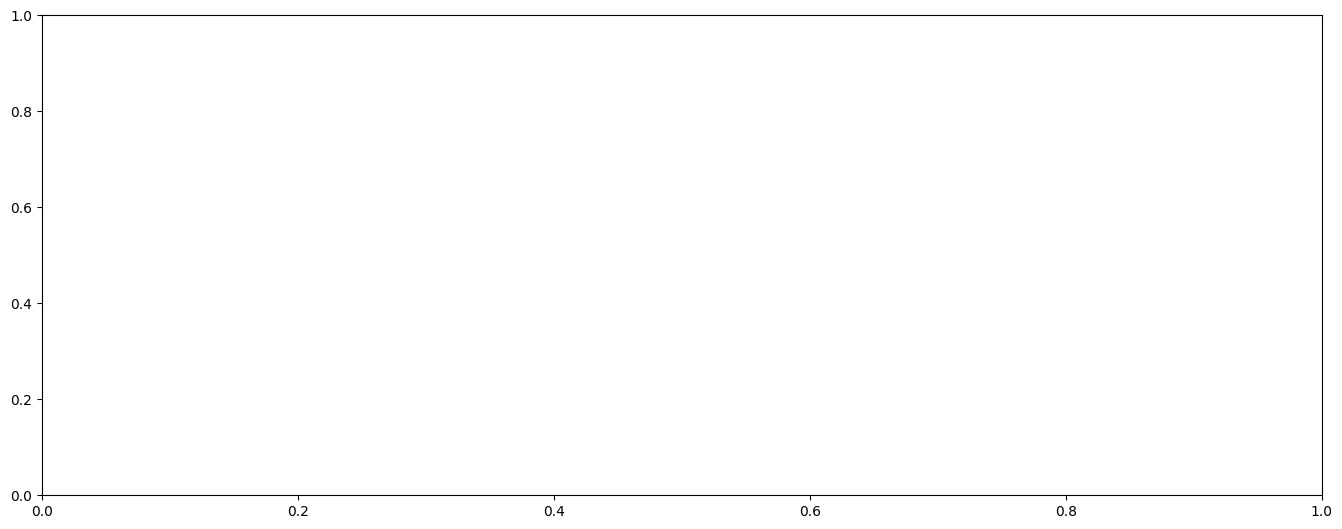

In [19]:
# time fitting
print("\n  ------------------------------------  Fitting Stage  --------------------------------------- \n")

minFit = 1
maxFit = 100

# Plot data points again
fig_fit = plt.figure(figsize=(16, 8))
frame1 = fig_fit.add_axes((.1,.3,.8,.6))
plt.errorbar(Nworkers[minPlot:maxPlot], Ncompanies[minPlot:maxPlot], yerr=eNcompanies[minPlot:maxPlot], fmt='.', linewidth=2,
                color="blue", label='Data (2020)')
#ax_fit.set(xlabel="Size of company (in FTE)", ylabel="Number of companies", title="")
plt.xlabel( "Size of company (in FTE)",fontsize=16)
plt.ylabel("Number of companies",fontsize=16)
#plt.yscale('log')
plt.legend(fontsize=16);

# Power Law fit:
# --------------
def ChiSquare_exponential(N, alpha):
    Ncompanies_est = func_Exponential(Nworkers[minFit:maxFit], N, alpha)
    chi2 = np.sum(((Ncompanies[minFit:maxFit] - Ncompanies_est) / eNcompanies[minFit:maxFit]) ** 2)
    return chi2

minuit = Minuit(ChiSquare_exponential, N=50000.0, alpha=2.0)
minuit.errordef = 1.0   # Chi2 fit
minuit.migrad();
if (not minuit.fmin.is_valid):
    print("  WARNING: The ChiSquare fit DID NOT converge!!! ")

for name in minuit.parameters:
    print("Fit value (exp): {0} = {1:.5f} +/- {2:.5f}".format(name, minuit.values[name], minuit.errors[name]))
chi2 = minuit.fmin.fval
Ndof = len(Ncompanies[minFit:maxFit]) - len(minuit.values[:])
Prob = stats.chi2.sf(chi2, Ndof)
print(f"  Model fit:  Prob(Chi2={chi2:6.1f}, Ndof={Ndof:3d}) = {Prob:7.5f}")

N_fit, alpha_fit = minuit.values[:]
eN_fit, ealpha_fit = minuit.errors[:]
plt.plot(Nworkers[minFit:maxFit], func_Exponential_vec(Nworkers[minFit:maxFit], N_fit, alpha_fit), 'red', linewidth=2.0,
            label=f'Fit with Exponential (Chi2 = {chi2:6.1f})')

difference = func_Exponential_vec(Nworkers[minFit:maxFit], N_fit, alpha_fit)/ Ncompanies[minFit:maxFit]
frame2 = fig_fit.add_axes((.1,.1,.8,.2))        
plt.plot(Nworkers[minFit:maxFit],difference,'.', color="red")
plt.grid()